In [31]:
import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider


from utils import run_and_cache
from TSTtrainer import  TimeSeriesTransformer, load_dataset

In [3]:
torch.manual_seed(123)
np.random.seed(123)

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [5]:
ACTIVATION_TENSOR = None

In [6]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, sparsity_lambda=1e-3):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.sparsity_lambda = sparsity_lambda

    def forward(self, x):
        h = F.relu(self.encoder(x))
        x_hat = self.decoder(h)
        return x_hat, h
    
    def loss(self, x, x_hat, h):
        reconstruction_loss = F.mse_loss(x_hat, x)
        sparsity_penalty = self.sparsity_lambda * torch.sum(torch.abs(h))
        return reconstruction_loss + sparsity_penalty

In [7]:
MODEL_PATH = "TST_japanesevowels.pth"
DATASET_NAME = "JapaneseVowels"


In [8]:
train_loader, test_loader = load_dataset(DATASET_NAME, batch_size=4)

full_train_inputs = []
full_train_labels = []
for x, y in train_loader:
    full_train_inputs.append(x)
    full_train_labels.append(y)

train_batch = torch.cat(full_train_inputs).to(DEVICE)  # (N, seq_len, channels)
label_batch = torch.cat(full_train_labels)             # (N,)

train_labels = label_batch
seq_len, channels = train_batch.shape[1], train_batch.shape[2]
num_classes = int(train_labels.max().item()) + 1

model = TimeSeriesTransformer(
    input_dim=channels,
    num_classes=num_classes,
    seq_len=seq_len
)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE).eval()

C:\Users\matis\AppData\Local\Temp\ipykernel_30180\391293175.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DE

In [9]:
for name, module in model.named_modules():
    print(name)


conv1
bn1
conv2
bn2
conv3
bn3
transformer_encoder
transformer_encoder.layers
transformer_encoder.layers.0
transformer_encoder.layers.0.self_attn
transformer_encoder.layers.0.self_attn.out_proj
transformer_encoder.layers.0.linear1
transformer_encoder.layers.0.dropout
transformer_encoder.layers.0.linear2
transformer_encoder.layers.0.norm1
transformer_encoder.layers.0.norm2
transformer_encoder.layers.0.dropout1
transformer_encoder.layers.0.dropout2
transformer_encoder.layers.1
transformer_encoder.layers.1.self_attn
transformer_encoder.layers.1.self_attn.out_proj
transformer_encoder.layers.1.linear1
transformer_encoder.layers.1.dropout
transformer_encoder.layers.1.linear2
transformer_encoder.layers.1.norm1
transformer_encoder.layers.1.norm2
transformer_encoder.layers.1.dropout1
transformer_encoder.layers.1.dropout2
transformer_encoder.layers.2
transformer_encoder.layers.2.self_attn
transformer_encoder.layers.2.self_attn.out_proj
transformer_encoder.layers.2.linear1
transformer_encoder.lay

In [10]:
LAYER_TARGETS = ["transformer_encoder.layers.0.linear2"]

In [11]:
cache = run_and_cache(model, train_batch, targets=LAYER_TARGETS)
activations = list(cache.values())[0]
ACTIVATION_TENSOR = activations.view(-1, activations.size(-1)).cpu()
total_timesteps, feature_dim = ACTIVATION_TENSOR.shape

# we know each instance is seq_len long
seq_len = train_batch.shape[1]

# compute how many instances we have
num_instances = total_timesteps // seq_len
assert num_instances * seq_len == total_timesteps, \
       "timesteps not divisible by seq_len!"

# now reshape
sequences = ACTIVATION_TENSOR.view(num_instances, seq_len, feature_dim)  # (num_instances, seq_len, feature_dim)
labels = train_labels  # shape (num_instances,)


In [12]:
dataset = TensorDataset(sequences, labels)
loader  = DataLoader(dataset, batch_size=8, shuffle=True)

# Training the Model below! Don't run if don't want to!

In [13]:

hidden_dim = 128
sparsity_lambda = 1e-4


sae    = SparseAutoencoder(feature_dim, hidden_dim, sparsity_lambda).to(DEVICE)
opt    = torch.optim.Adam(sae.parameters(), lr=1e-3)
epochs = 1000

for epoch in range(epochs):
    sae.train()
    total_loss = 0.
    for seq_batch, _ in loader:
        x = seq_batch.view(-1, feature_dim).to(DEVICE)   # flatten timesteps
        x_hat, h = sae(x)
        l = sae.loss(x, x_hat, h)

        opt.zero_grad()
        l.backward()
        opt.step()

        total_loss += l.item() * x.size(0)
    print(f"Epoch {epoch:3d} — Loss: {total_loss/len(loader.dataset):.4f}")
    
torch.save(sae.state_dict(), "sae_enc0lin2.pth")

Epoch   0 — Loss: 12.5008
Epoch   1 — Loss: 9.7577
Epoch   2 — Loss: 7.9108
Epoch   3 — Loss: 6.6271
Epoch   4 — Loss: 5.8743
Epoch   5 — Loss: 5.3440
Epoch   6 — Loss: 4.9449
Epoch   7 — Loss: 4.6770
Epoch   8 — Loss: 4.4569
Epoch   9 — Loss: 4.2870
Epoch  10 — Loss: 4.1362
Epoch  11 — Loss: 4.0010
Epoch  12 — Loss: 3.8904
Epoch  13 — Loss: 3.7904
Epoch  14 — Loss: 3.7007
Epoch  15 — Loss: 3.6260
Epoch  16 — Loss: 3.5499
Epoch  17 — Loss: 3.4812
Epoch  18 — Loss: 3.4151
Epoch  19 — Loss: 3.3489
Epoch  20 — Loss: 3.2908
Epoch  21 — Loss: 3.2260
Epoch  22 — Loss: 3.1655
Epoch  23 — Loss: 3.1009
Epoch  24 — Loss: 3.0521
Epoch  25 — Loss: 3.0017
Epoch  26 — Loss: 2.9529
Epoch  27 — Loss: 2.9129
Epoch  28 — Loss: 2.8735
Epoch  29 — Loss: 2.8341
Epoch  30 — Loss: 2.8043
Epoch  31 — Loss: 2.7726
Epoch  32 — Loss: 2.7473
Epoch  33 — Loss: 2.7130
Epoch  34 — Loss: 2.6885
Epoch  35 — Loss: 2.6665
Epoch  36 — Loss: 2.6451
Epoch  37 — Loss: 2.6237
Epoch  38 — Loss: 2.5959
Epoch  39 — Loss: 2.5756

# Loading Pretrained model!

In [13]:
def load_trained_sae(path="sae_enc0lin2.pth", input_dim=None, hidden_dim=128, sparsity_lambda=1e-4):
    sae = SparseAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim, sparsity_lambda=sparsity_lambda).to(DEVICE)
    sae.load_state_dict(torch.load(path, map_location=DEVICE))
    sae.eval()
    return sae

sae = load_trained_sae(input_dim=feature_dim)


C:\Users\matis\AppData\Local\Temp\ipykernel_30180\459944350.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae.load_state_dict(torch.load(path, map_location=DEVICE))


In [14]:
# load test batch

full_test_inputs = []
full_test_labels = []
for x, y in test_loader:
    full_test_inputs.append(x)
    full_test_labels.append(y)

test_batch = torch.cat(full_test_inputs).to(DEVICE)
test_labels = torch.cat(full_test_labels)

In [15]:
# cache activations on thest set
cache_test = run_and_cache(model, test_batch, targets=LAYER_TARGETS)
test_activations = list(cache_test.values())[0]  # (N, T, D)
test_activations = test_activations.view(-1, test_activations.size(-1)).cpu()

# reshape
total_timesteps, feat_dim = test_activations.shape
seq_len = test_batch.shape[1]
num_instances = total_timesteps // seq_len
assert num_instances * seq_len == total_timesteps, "Test timesteps not divisible by seq_len!"

test_raw_seqs = test_activations.view(num_instances, seq_len, feat_dim)  # (N, T, D)

In [16]:
# compute SAE hidden activations
sae.eval()
with torch.no_grad():
    flat_test_raw      = test_raw_seqs.view(-1, feat_dim).to(DEVICE)  # (N*T, D)
    _, flat_test_hidden = sae(flat_test_raw)  # (N*T, H)
    test_hidden_seqs    = flat_test_hidden.view(num_instances, seq_len, -1)
    
    
idx = 33  # pick instance
raw_inst    = test_raw_seqs[idx].T.cpu().numpy()    # (D, T)
hidden_inst = test_hidden_seqs[idx].T.cpu().numpy() # (H, T)
true_label  = test_labels[idx].item()

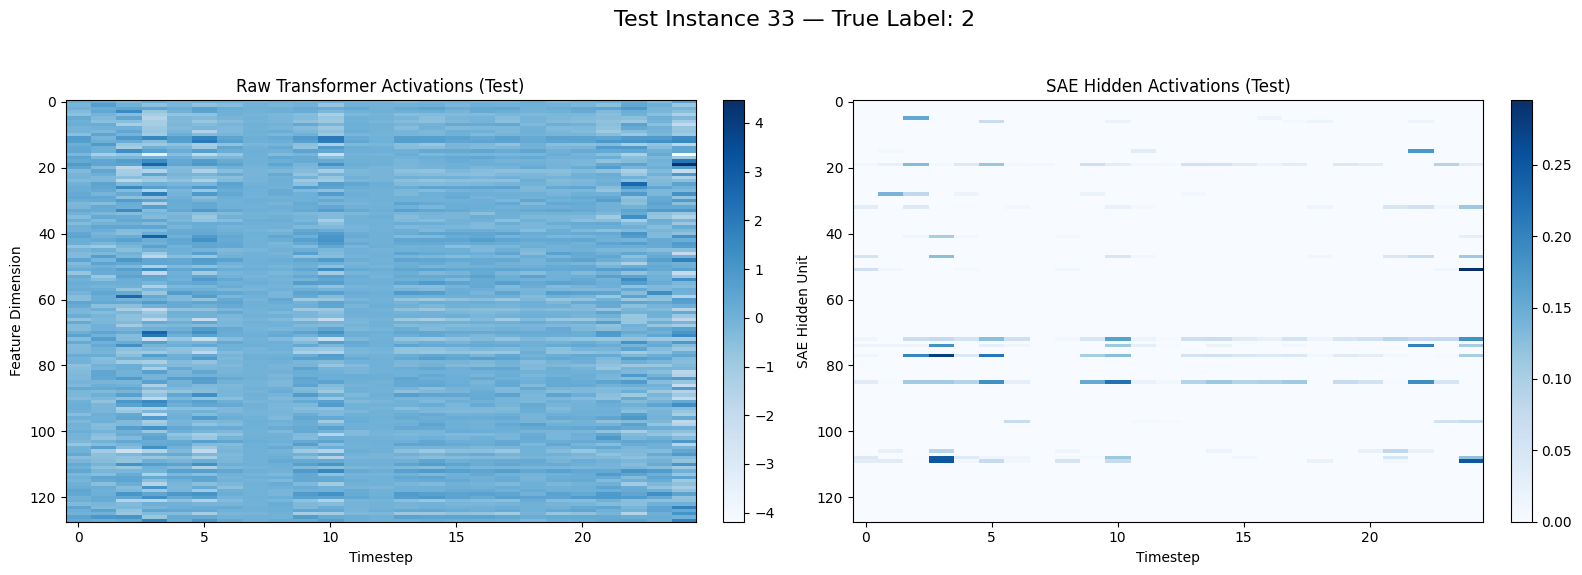

In [17]:
# plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

im0 = axes[0].imshow(raw_inst, aspect='auto', cmap='Blues')
axes[0].set_title(f"Raw Transformer Activations (Test)")
axes[0].set_xlabel("Timestep")
axes[0].set_ylabel("Feature Dimension")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(hidden_inst, aspect='auto', cmap='Blues')
axes[1].set_title(f"SAE Hidden Activations (Test)")
axes[1].set_xlabel("Timestep")
axes[1].set_ylabel("SAE Hidden Unit")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

fig.suptitle(f"Test Instance {idx} — True Label: {true_label}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [18]:
N, T, H = test_hidden_seqs.shape
test_hidden_np = test_hidden_seqs.cpu().numpy()  # (N, T, H)

test_inputs_np = test_batch.cpu().numpy()        # (N, T, C)
test_labels_np = test_labels.cpu().numpy()       # (N,)

In [39]:
def show_topk_for_neuron_timestep(neuron_idx=0, timestep=0):
    values = test_hidden_np[:, timestep, neuron_idx]  # shape (N,)
    
    # `--------------------CHANGE HERE \/-------
    topk_indices = np.argsort(values)[-40:][::-1]  # top k sorted descending
    topk_values  = values[topk_indices]

    print(f"Neuron {neuron_idx} @ Timestep {timestep} — Top-5 Activations")

    for rank, idx in enumerate(topk_indices):
        label = test_labels_np[idx]
        act_val = topk_values[rank]
        ts_input = test_inputs_np[idx]     # (T, C)
        hidden_inst = test_hidden_np[idx].T  # (H, T)

        fig, axes = plt.subplots(1, 2, figsize=(16, 5))

        time = np.arange(ts_input.shape[0])
        for ch in range(ts_input.shape[1]):
            axes[0].plot(time, ts_input[:, ch], label=f'Ch {ch}')
        axes[0].axvline(timestep, color='red', linestyle='--', label='Timestep')  # << Add red line here
        axes[0].set_title(f"[Rank {rank+1}] Raw Time Series — Instance {idx} (Label {label})")
        axes[0].set_xlabel("Timestep")
        axes[0].set_ylabel("Value")

        im1 = axes[1].imshow(hidden_inst, aspect='auto', interpolation='nearest', cmap='Blues')
        # axes[1].axhline(neuron_idx, color='red', linestyle='--', label='Neuron')
        axes[1].axvline(timestep, color='orange', linestyle=':', label='Timestep')
        axes[1].legend()
        axes[1].set_title(f"SAE Activations — Act[{neuron_idx},{timestep}] = {act_val:.3f}")
        axes[1].set_xlabel("Timestep")
        axes[1].set_ylabel("SAE Unit")
        plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

        plt.suptitle(f"Top-{rank+1} Activation for Neuron {neuron_idx} @ Timestep {timestep}", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

In [40]:

interact(
    show_topk_for_neuron_timestep,
    neuron_idx=IntSlider(min=0, max=127, step=1, value=0, description="Neuron"),
    timestep=IntSlider(min=0, max=test_batch.shape[1]-1, step=1, value=0, description="Timestep")
)

interactive(children=(IntSlider(value=0, description='Neuron', max=127), IntSlider(value=0, description='Times…

<function __main__.show_topk_for_neuron_timestep(neuron_idx=0, timestep=0)>